# PEAS Meal Networks Analysis

# Set up
This notebook requires several modules. If you do not have them run the cell below, else skip

## Load in the necessary libraries/packages/modules

In [4]:
! pip install  python-louvain --user



  Created wheel for python-louvain: filename=python_louvain-0.13-cp37-none-any.whl size=9223 sha256=dc850a8940fe6c2667d973910ba28a4d53409404dfb493dc7910167f1dedfc92
  Stored in directory: /home/jovyan/.cache/pip/wheels/f9/74/a9/14f051b00dddd46d71529db15507796da13a43ee2c0bc39def
Successfully built python-louvain


In [77]:
import os
import networkx as nx
import numpy as np
import pandas as pd
import glob
import community
import pdb

import matplotlib.pyplot as plt


from scipy import linalg
from sklearn.covariance import GraphLassoCV
from sklearn import covariance, preprocessing


In [12]:
basepath='/home/jovyan/work/data'

## Read in the data

In [13]:
file_dict={'infant': {}, 'young':{},'child':{},'mom':{}}

In [14]:
file_dict["mom"]["files"] = [x for x in glob.glob(os.path.join(basepath,'*HEI.csv')) if "Mom" in x]
file_dict["infant"]["files"] = [x for x in glob.glob(os.path.join(basepath,'*HEI.csv')) if "infant" in x]
file_dict["young"]["files"] = [x for x in glob.glob(os.path.join(basepath,'*HEI.csv')) if "young" in x]
file_dict["child"]["files"] = [x for x in glob.glob(os.path.join(basepath,'*HEI.csv')) if "child" in x]

In [15]:
file_dict

{'infant': {'files': ['/home/jovyan/work/data/DF_infant_infant_HEI.csv']},
 'young': {'files': ['/home/jovyan/work/data/DF_young_young_HEI.csv']},
 'child': {'files': ['/home/jovyan/work/data/DF_child_child_HEI.csv']},
 'mom': {'files': ['/home/jovyan/work/data/Mom_dailyhei0409_HEI.csv',
   '/home/jovyan/work/data/Mom_hei0409_HEI.csv']}}

In [16]:
data_dict={'infant': {}, 'young':{},'child':{},'mom':{}}

In [17]:
for key, value in file_dict.items():
    for dat in value['files']:
        subkey=dat.split('/')[-1].split('.')[0]
        data_dict[key][subkey]=pd.read_csv(dat,sep=',')

# Make correlations

In [ ]:
corr_dict={'infant': {}, 'young':{},'child':{},'mom':{}}

In [ ]:
for key, value in data_dict.items():
    for k, data in value.items():
        lw_cov_, _ = ledoit_wolf(data)
        lw_prec_ = linalg.inv(lw_cov_)


In [61]:
X=data_dict['child']['DF_child_child_HEI'][
    ['hei_totveg','hei_greensbeans','hei_totfruit','hei_wholefruit','hei_wholegrains','hei_dairy','hei_totproteins','hei_seafoodplantprot','hei_refinedgrains','hei_fruitjuice','hei_SSB','chocolate_candies','candies','frosting','sweet_sauce','sugar','syrups','Pudding','icecream','nondairy_treat','baked_good','chips','fries','other_fried','formula_foz','cereal_oz','bbcereal_hcup','hei_sweets','hei_salty','hei_vegetables','hei_proteins','hei_milk','hei_cereal']]

In [62]:
X=X.loc[:, (X != 0).any(axis=0)]

After normalizing your input data, the eigenvalues of your empirical covariance matrix still span a relatively large range of about [0-8]. Shrinking this using the sklearn.covariance.shrunk_covariance() function can bring it into a more computationally acceptable range (from what I've read, [0,1] is ideal but slgihtly larger ranges also appear to work).  
https://stats.stackexchange.com/questions/172911/graphical-lasso-numerical-problem-not-spd-matrix-result

In [63]:

X = X.values.astype('float64')
myScaler = preprocessing.StandardScaler()
X = myScaler.fit_transform(X)
emp_cov = covariance.empirical_covariance(X)
shrunk_cov = covariance.shrunk_covariance(emp_cov, shrinkage=0.9) # Set shrinkage closer to 1 for poorly-conditioned data

alphaRange = 10.0 ** np.arange(-8,0) # 1e-7 to 1e-1 by order of magnitude
for alpha in alphaRange:
    try: 
        graphCov = covariance.graph_lasso(shrunk_cov, alpha)
        print("Calculated graph-lasso covariance matrix for alpha=%s"%alpha)
    except FloatingPointError:
        print("Failed at alpha=%s"%alpha)

Calculated graph-lasso covariance matrix for alpha=1e-08
Calculated graph-lasso covariance matrix for alpha=1e-07
Calculated graph-lasso covariance matrix for alpha=1e-06
Calculated graph-lasso covariance matrix for alpha=1e-05
Calculated graph-lasso covariance matrix for alpha=0.0001
Calculated graph-lasso covariance matrix for alpha=0.001
Calculated graph-lasso covariance matrix for alpha=0.01
Calculated graph-lasso covariance matrix for alpha=0.1


In [69]:
from sklearn.covariance import ledoit_wolf

model = GraphLassoCV(alphas=[10,15,20,25], cv=5)
model.fit(X)

cov_ = model.covariance_
prec_ = model.precision_
al_ = model.alpha_

lw_cov_, _ = ledoit_wolf(X)
lw_prec_ = linalg.inv(lw_cov_)


/opt/conda/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:228: RuntimeWarning: divide by zero encountered in double_scalars
  - np.dot(covariance_[indices != idx, idx], coefs)))
/opt/conda/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/opt/conda/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/opt/conda/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:51: RuntimeWarning: invalid value encountered in multiply
  gap = np.sum(emp_cov * precision_)
/opt/conda/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:54: RuntimeWarning: invalid value encountered in absolute
  - np.abs(np.diag(precision_)).sum())
/opt/conda/lib/python3.6/site-packages/sklearn/covariance/empirical_covariance_.py:43: RuntimeWarning: invalid value encountered in multiply
  log_likelihood_ = - np.sum(emp_cov 

In [75]:
lw_cov_.shape

(26, 26)

AttributeError: 'GraphLassoCV' object has no attribute 'grid_scores_'

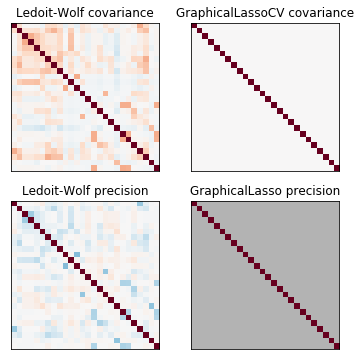

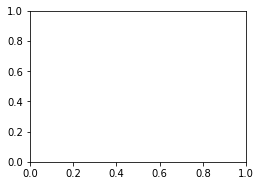

In [76]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [('Ledoit-Wolf', lw_cov_),
        ('GraphicalLassoCV', cov_)]
vmax = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(this_cov, interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s covariance' % name)


# plot the precisions
precs = [ ('Ledoit-Wolf', lw_prec_),
         ('GraphicalLasso', prec_)]
vmax = .9 * prec_.max()
for i, (name, this_prec) in enumerate(precs):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(np.ma.masked_equal(this_prec, 0),
               interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s precision' % name)
    if hasattr(ax, 'set_facecolor'):
        ax.set_facecolor('.7')
    else:
        ax.set_axis_bgcolor('.7')

# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([.2, .15, .75, .7])
plt.plot(model.cv_alphas_, np.mean(model.grid_scores_, axis=1), 'o-')
plt.axvline(model.alpha_, color='.5')
plt.title('Model selection')
plt.ylabel('Cross-validation score')
plt.xlabel('alpha')

plt.show()

## This is making a dictionary with the food options for networkX

In [ ]:
labels = data.index
labels_dict = {}
n=0
for item in labels:
    labels_dict[n]=item
    n=n+1

# Creating the graph object

In [ ]:
G = nx.from_numpy_matrix(data.values)

## Check edges

In [ ]:
G.edges(data=True)

## Set node attributes with the food data

In [ ]:
nx.set_node_attributes(G,labels_dict,'food')

## Check nodes

In [ ]:
G.nodes(data=True)

# Make a nice graph
The output you made can be made with edge weights using the 'spring' option 

In [ ]:
def create_corr_network(G, *argv):
    # creates a list for edges and for the weights
    # G must be a networkx graph object
    # Style = Choice of graph = circle, spring, spectral
    
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    
    
    #positions
    if len(argv) != 0:
        for arg in argv:
            print("Making %s graph"%arg)
            if arg == "circle":
                positions=nx.circular_layout(G)
            elif arg == "spring":
                positions=nx.spring_layout(G)
            elif arg == "spectral":
            
                positions=nx.spectral_layout(G)
    else:
        positions=nx.circular_layout(G)

    #Figure size
    plt.figure(figsize=(15,15))

    #draws nodes
    nx.draw_networkx_nodes(G,positions,node_color='#DA70D6',
                           node_size=500,alpha=0.8)
    labels=dict(G.nodes(data=True))
    #Styling for labels
    
    
    nx.draw_networkx_labels(G,positions,labels, font_size=8, 
                            font_family='sans-serif')
        
    #draws the edges
    vmin = min(weights)
    vmax = max(weights)
    
    w=np.array(weights)*10
    nx.draw_networkx_edges(G, positions, edge_list=edges, style='solid', width= w, edge_color= weights, 
                           edge_cmap=plt.cm.seismic, vmin=vmin, vmax=vmax)
    
    # displays the graph without axis
    plt.axis('off')
    #saves image
    #plt.savefig("part1.png", format="PNG")
    sm = plt.cm.ScalarMappable(cmap=plt.cm.seismic, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)
    plt.show() 

In [ ]:
create_corr_network(G, 'spring')

# Next steps
If you have a regular structure for directories I can write a function that will pick up the csv files and run all of this at once. This is a general tutorial. As we get closer to publication we can make the graphs pretty. The next things to consider are graph metrics. I recommend modularity, participation coefficient, and clustering coefficient. 